Comp 4447 Final Project
Predict Box Office Opening Weekend Revenue
By: Arisbeth Laguna, Dan Jung and Matt Ostendorf

Github Link: 

https://github.com/Ostendma/TOOL1_FINAL_PROJECT

Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split , RandomizedSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from sklearn.preprocessing import StandardScaler
import json
import re
from sklearn.tree import plot_tree

Create Random State Variable

In [2]:
rand_state = 425

Read in data files to dataframes

In [3]:
movie_data = pd.read_csv('OMDB API Data.csv')
CPI_data = pd.read_csv('CPI Data.csv')
NLP_data = pd.read_csv('NLP Data.csv')

Display few rows of movie data

In [4]:
pd.set_option('display.max_columns', None)
movie_data.head(5)

,imdbID,TT URL,Opening Revenue,RL URL,Number of Theaters,tmdbID,url,budget,original_title,title,overview,production_company,belongs_to_collection,omdb title,year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings_IMDB,Ratings_Rotten,Ratings_Metacritic,Metascore,imdbRating,imdbVotes,Type,DVD,BoxOffice,Production,Website,Response
0,tt0338751,https://www.boxofficemojo.com/title/tt00338751...,"$858,021",https://www.boxofficemojo.com/release/rl742753...,40,2567,https://api.themoviedb.org/3/movie/2567?api_ke...,110000000.0,The Aviator,The Aviator,A biopic depicting the life of filmmaker and a...,"[{'id': 14, 'logo_path': '/m6AHu84oZQxvq7n1rsv...",NaN,The Aviator,2004.0,PG-13,12/25/2004,170 min,"Biography, Drama",Martin Scorsese,John Logan,"Leonardo DiCaprio, Cate Blanchett, Kate Beckin...",A biopic depicting the early years of legendar...,"English, Persian","United States, Germany",Won 5 Oscars. 89 wins &amp; 131 nominations total,https://m.media-amazon.com/images/M/MV5BZTYzMj...,7.5/10,86%,77/100,77.0,7.5,"376,165",movie,19-Apr-16,"$102,610,330",NaN,NaN,True
1,tt0293508,https://www.boxofficemojo.com/title/tt00293508...,"$4,001,890",https://www.boxofficemojo.com/release/rl121480...,622,9833,https://api.themoviedb.org/3/movie/9833?api_ke...,70000000.0,The Phantom of the Opera,The Phantom of the Opera,"Deformed since birth, a bitter man known only ...","[{'id': 174, 'logo_path': '/IuAlhI9eVC9Z8UQWOI...",NaN,The Phantom of the Opera,2004.0,PG-13,1/21/2005,143 min,"Drama, Musical, Romance",Joel Schumacher,"Gaston Leroux, Andrew Lloyd Webber, Joel Schum...","Gerard Butler, Emmy Rossum, Patrick Wilson",A young soprano becomes the obsession of a dis...,"English, Italian","United Kingdom, United States",Nominated for 3 Oscars. 7 wins &amp; 42 nomina...,https://m.media-amazon.com/images/M/MV5BNDczNz...,7.2/10,33%,40/100,40.0,7.2,"128,266",movie,27-Dec-11,"$51,293,931",NaN,NaN,True
2,tt0363473,https://www.boxofficemojo.com/title/tt00363473...,"$45,264",https://www.boxofficemojo.com/release/rl332637...,6,6478,https://api.themoviedb.org/3/movie/6478?api_ke...,25000000.0,Beyond the Sea,Beyond the Sea,Based on the life and career of legendary ente...,"[{'id': 1632, 'logo_path': '/cisLn1YAUuptXVBa0...",NaN,Beyond the Sea,2004.0,PG-13,12/29/2004,118 min,"Biography, Drama, Music",Kevin Spacey,"Kevin Spacey, Lewis Colick","Kevin Spacey, Kate Bosworth, John Goodman","A swooning study of ""Mack the Knife"" singer Bo...","English, Italian","United Kingdom, Germany, United States",7 nominations,https://m.media-amazon.com/images/M/MV5BMTY2Mz...,6.7/10,42%,46/100,46.0,6.7,"15,400",movie,1-Oct-16,"$6,318,709",NaN,NaN,True
3,tt0361127,https://www.boxofficemojo.com/title/tt00361127...,"$53,985",https://www.boxofficemojo.com/release/rl494568...,6,9692,https://api.themoviedb.org/3/movie/9692?api_ke...,0.0,The Woodsman,The Woodsman,A paedophile returns to his hometown after 12 ...,"[{'id': 695, 'logo_path': '/rxXG5CZjBGFbJt9tYg...",NaN,The Woodsman,2004.0,R,1/28/2005,87 min,Drama,Nicole Kassell,"Steven Fechter, Nicole Kassell","Kevin Bacon, Kyra Sedgwick, Yasiin Bey",A child molester returns to his hometown after...,English,United States,7 wins &amp; 20 nominations,https://m.media-amazon.com/images/M/MV5BMTk2ND...,7.2/10,88%,72/100,72.0,7.2,"34,905",movie,14-Dec-16,"$1,576,231",NaN,NaN,True
4,tt0385267,https://www.boxofficemojo.com/title/tt00385267...,"$151,750",https://www.boxofficemojo.com/release/rl915880...,3,1901,https://api.themoviedb.org/3/movie/1901?api_ke...,0.0,In Good Company,In Good Company,Dan Foreman is a seasoned advertisement sales ...,"[{'id': 1473, 'logo_path': None, 'name': 'Dept...",NaN,In Good Company,2004.0,PG-13,1/14/2005,109 min,"Comedy, Drama, Romance",Paul Weitz,Paul Weitz,"Dennis Quaid, Topher Grace, Scarlett Johansson",A middle-aged ad exec is faced with a new boss...,English,United States,2 wins &amp; 8 nominations,https://m.media-amazon.com/images/M/MV5BZjI3MT...,6.5/10,82%,66/100,66.0,6.

In [5]:
#Dropping duplicate rows
movie_data.drop(['imdbRating', 'Metascore'], axis=1, inplace=True)

Display a few rows of CPI data

In [6]:
CPI_data.head(5)

,Year,1,2,3,4,5,6,7,8,9,10,11,12,HALF1,HALF2
0,1913,9.8,9.8,9.8,9.8,9.7,9.8,9.9,9.9,10.0,10.0,10.1,10.0,NaN,NaN
1,1914,10.0,9.9,9.9,9.8,9.9,9.9,10.0,10.2,10.2,10.1,10.2,10.1,NaN,NaN
2,1915,10.1,10.0,9.9,10.0,10.1,10.1,10.1,10.1,10.1,10.2,10.3,10.3,NaN,NaN
3,1916,10.4,10.4,10.5,10.6,10.7,10.8,10.8,10.9,11.1,11.3,11.5,11.6,NaN,NaN
4,1917,11.7,12.0,12.0,12.6,12.8,13.0,12.8,13.0,13.3,13.5,13.5,13.7,NaN,NaN


Review the types of data in movie data

In [7]:
print(movie_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13005 entries, 0 to 13004
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdbID                 13005 non-null  object 
 1   TT URL                 13005 non-null  object 
 2   Opening Revenue        13005 non-null  object 
 3   RL URL                 13005 non-null  object 
 4   Number of Theaters     13005 non-null  object 
 5   tmdbID                 13005 non-null  int64  
 6   url                    13005 non-null  object 
 7   budget                 12973 non-null  float64
 8   original_title         12973 non-null  object 
 9   title                  12973 non-null  object 
 10  overview               12972 non-null  object 
 11  production_company     12973 non-null  object 
 12  belongs_to_collection  1845 non-null   object 
 13  omdb title             12999 non-null  object 
 14  year                   12999 non-null  float64
 15  Ra

In [8]:
#Look for null values
movie_data.isnull().sum()

imdbID                       0
TT URL                       0
Opening Revenue              0
RL URL                       0
Number of Theaters           0
tmdbID                       0
url                          0
budget                      32
original_title              32
title                       32
overview                    33
production_company          32
belongs_to_collection    11160
omdb title                   6
year                         6
Rated                      616
Released                    64
Runtime                     25
Genre                       24
Director                    33
Writer                     572
Actors                      83
Plot                        27
Language                    41
Country                     24
Awards                    2133
Poster                      24
Ratings_IMDB                26
Ratings_Rotten            1032
Ratings_Metacritic        2606
imdbVotes                   24
Type                         6
DVD     

The columns Writers, Awards, DVD, Production and Website are missing a lot of values. We will remove them from our analysis

In [9]:
movie_data.drop(['Writer','Awards', 'DVD','Production', 'Website'], axis=1, inplace=True)

We are looking to predict domestic box office opening weekend revenue. Therefore we only want movies that were released in the United States. We will review the Country column to find movies only in the US.

In [10]:
#Checks to see if United States is in Country. If it is return Yes if not return None
def check_country(row):
    if pd.notna(row['Country']): 
        if 'United States' in row['Country']:
            return 'Yes'
    return None    
    
movie_data['USA Released'] = movie_data.apply(check_country, axis=1)

In [11]:
movie_data['USA Released'].isna().sum()

3397

Remove NA values from USA Relesead

In [12]:
movie_data.dropna(subset=['USA Released'], inplace=True)

Need to change the columns Opening Revenue, Number of Theaters, Runtime, Ratings_IMDB, Ratings_Rotten and Ratings_Metacritic to be the correct data type

In [13]:
#Need to remove dollar signs and commas and make integers from opening revenue
movie_data['Opening Revenue'].head(5)

0      $858,021 
1    $4,001,890 
2       $45,264 
3       $53,985 
4      $151,750 
Name: Opening Revenue, dtype: object

In [14]:
movie_data['Opening Revenue'] = movie_data['Opening Revenue'].str.replace('[$,]', '', regex=True).astype(float)

In [15]:
#Need to change number of theaters to int
movie_data['Number of Theaters'] = movie_data['Number of Theaters'].str.replace('[,]', '', regex=True).astype(int)

In [16]:
#Change runtime to float
movie_data['Runtime'].head(5)

0    170 min
1    143 min
2    118 min
3     87 min
4    109 min
Name: Runtime, dtype: object

In [17]:
movie_data['Runtime'] = movie_data['Runtime'].str.replace('min', '', regex=True).astype(float)

In [18]:
#Convert Ratings_IMDB to float
movie_data['Ratings_IMDB'].head(5)

0    7.5/10
1    7.2/10
2    6.7/10
3    7.2/10
4    6.5/10
Name: Ratings_IMDB, dtype: object

In [19]:
#Converts IMDB rating to a percentage
def fix_IMDB_ratings(row):
    if pd.notna(row['Ratings_IMDB']): 
        return round(float(row['Ratings_IMDB'].split('/')[0])*10/100,4)
    
movie_data['Ratings_IMDB'] = movie_data.apply(fix_IMDB_ratings, axis=1)

In [20]:
#Convert Ratings_Rotten to float
movie_data['Ratings_Rotten'].head(5)

0    86%
1    33%
2    42%
3    88%
4    82%
Name: Ratings_Rotten, dtype: object

In [21]:
movie_data['Ratings_Rotten'] = movie_data['Ratings_Rotten'].str.replace('%', '', regex=True).astype(float)

In [22]:
#Now need to divide by 100 to get into decimal format
movie_data['Ratings_Rotten'] = movie_data['Ratings_Rotten'] /100

In [23]:
#Change meta critic to float
movie_data['Ratings_Metacritic'].head(5)

0    77/100
1    40/100
2    46/100
3    72/100
4    66/100
Name: Ratings_Metacritic, dtype: object

In [24]:
#Can use same logic as IMDB to get in float format
def fix_META_ratings(row):
    if pd.notna(row['Ratings_Metacritic']): 
        return round(float(row['Ratings_Metacritic'].split('/')[0])*10/100,4)
movie_data['Ratings_Metacritic'] = movie_data.apply(fix_META_ratings, axis=1)

Since the movies are all from different years we need to change the revenue to today's dollars. We will use the CPI to do this. Will need to split out month and year into different fields. Then apply the formula Opening Weekend Revenue x ending period CPI / Beginning period CPI 

In [25]:
#Create month field
def get_month(row):
    if pd.notna(row['Released']): 
        return int(row['Released'].split('/')[0])
movie_data['Month'] = movie_data.apply(get_month, axis=1)


In [26]:
#Create Year field
def get_year(row):
    if pd.notna(row['Released']): 
        return int(row['Released'].split('/')[2])
movie_data['Released Year'] = movie_data.apply(get_year, axis=1)


In [27]:
movie_data['Ending CPI'] = CPI_data['9'].max()

def get_Beg_CPI(row):
    for indexs, rows in CPI_data.iterrows():
        if rows['Year'] == row['Released Year']:
            return rows[int(row['Month'])]

movie_data['Beg CPI'] = movie_data.apply(get_Beg_CPI, axis=1)

C:\Users\mcogb\AppData\Local\Temp\ipykernel_7204\2638841218.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return rows[int(row['Month'])]


In [28]:
#Adjusted Revenue
movie_data['Adjusted_Opening_Weekend_Revenue'] = movie_data['Opening Revenue'] * movie_data['Ending CPI'] / movie_data['Beg CPI']

In [29]:
#Drop CPI values as not need any more along with opening revenue since we have calculated the correct value for it
movie_data.drop(['Ending CPI' ,'Beg CPI', 'Opening Revenue'], axis=1, inplace=True)

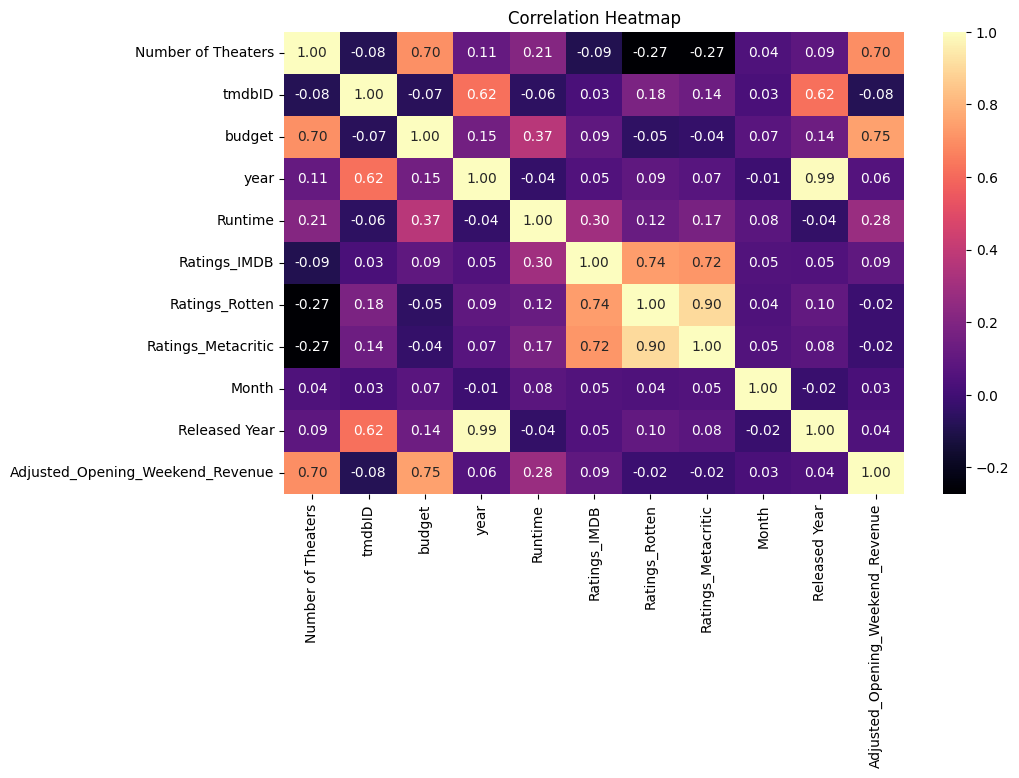

In [30]:
correlation_matrix = movie_data.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, cmap= 'magma', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

We see a high correlation between Ratings_IMDB, Ratings_Rotten and Ratings_Metacritic. This is not a surprise since they are all rating systems. Since, Ratings_IMDB has the best correlation with adjusted opening weekend revenue (the variable we will try to predict) we will use this and drop the other two.

In [31]:
movie_data.drop(['Ratings_Rotten', 'Ratings_Metacritic'], axis=1, inplace=True)

Review dataframe for null values

In [32]:
movie_data.isna().sum()

imdbID                                 0
TT URL                                 0
RL URL                                 0
Number of Theaters                     0
tmdbID                                 0
url                                    0
budget                                17
original_title                        17
title                                 17
overview                              18
production_company                    17
belongs_to_collection               8079
omdb title                             0
year                                   0
Rated                                197
Released                              19
Runtime                                1
Genre                                  0
Director                               2
Actors                                40
Plot                                   1
Language                              11
Country                                0
Poster                                 0
Ratings_IMDB    

The column Rated has 197 missing values. We will drop Those rows and see how many missing values we have after.

In [33]:
movie_data.dropna(subset=['Rated'],inplace=True)

In [34]:
movie_data.isna().sum()

imdbID                                 0
TT URL                                 0
RL URL                                 0
Number of Theaters                     0
tmdbID                                 0
url                                    0
budget                                15
original_title                        15
title                                 15
overview                              16
production_company                    15
belongs_to_collection               7888
omdb title                             0
year                                   0
Rated                                  0
Released                              18
Runtime                                0
Genre                                  0
Director                               2
Actors                                33
Plot                                   0
Language                               8
Country                                0
Poster                                 0
Ratings_IMDB    

We will now drop all rows that have NAs besides belongs to collection

In [35]:
cols_to_check = [col for col in movie_data.columns if col != 'belongs_to_collection']
movie_data = movie_data.loc[movie_data[cols_to_check].dropna().index]

In [36]:
movie_data.isna().sum()

imdbID                                 0
TT URL                                 0
RL URL                                 0
Number of Theaters                     0
tmdbID                                 0
url                                    0
budget                                 0
original_title                         0
title                                  0
overview                               0
production_company                     0
belongs_to_collection               7812
omdb title                             0
year                                   0
Rated                                  0
Released                               0
Runtime                                0
Genre                                  0
Director                               0
Actors                                 0
Plot                                   0
Language                               0
Country                                0
Poster                                 0
Ratings_IMDB    

In [37]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9333 entries, 0 to 13004
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   imdbID                            9333 non-null   object 
 1   TT URL                            9333 non-null   object 
 2   RL URL                            9333 non-null   object 
 3   Number of Theaters                9333 non-null   int32  
 4   tmdbID                            9333 non-null   int64  
 5   url                               9333 non-null   object 
 6   budget                            9333 non-null   float64
 7   original_title                    9333 non-null   object 
 8   title                             9333 non-null   object 
 9   overview                          9333 non-null   object 
 10  production_company                9333 non-null   object 
 11  belongs_to_collection             1521 non-null   object 
 12  omdb title

In [38]:
#Make year and month be type integer
movie_data['Released Year'] = movie_data['Released Year'].astype(int)
movie_data['Month'] = movie_data['Month'].astype(int)

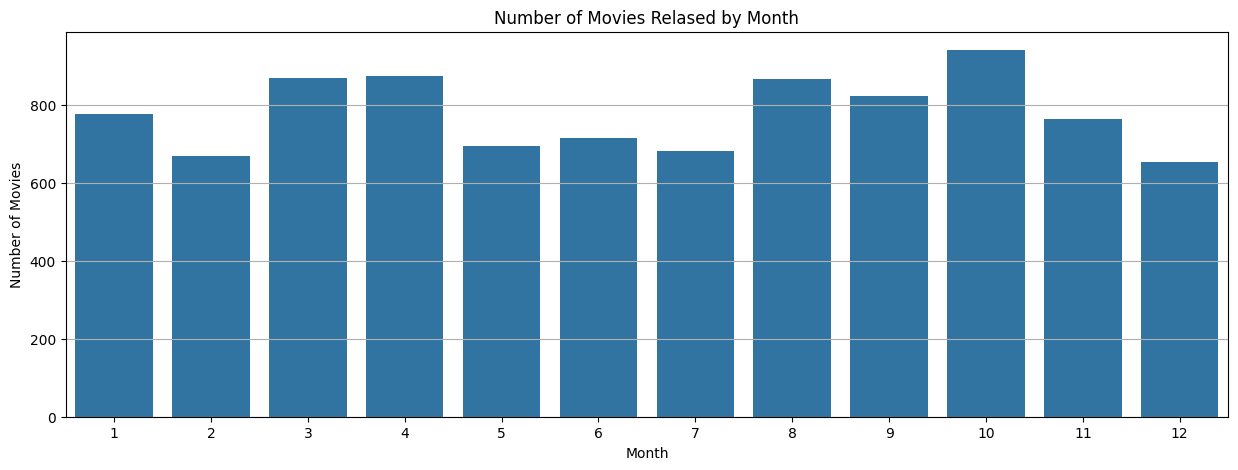

In [39]:
plt.figure(figsize = (15,5))
sns.barplot(x='Month', y='Month', data=movie_data, errorbar = None, estimator = 'count')
plt.title('Number of Movies Relased by Month')
plt.grid(axis='y')
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.show()

Based on the bar graph above we notice the May, June, July and December have the least amount of movies released historically. Where October have the most. 

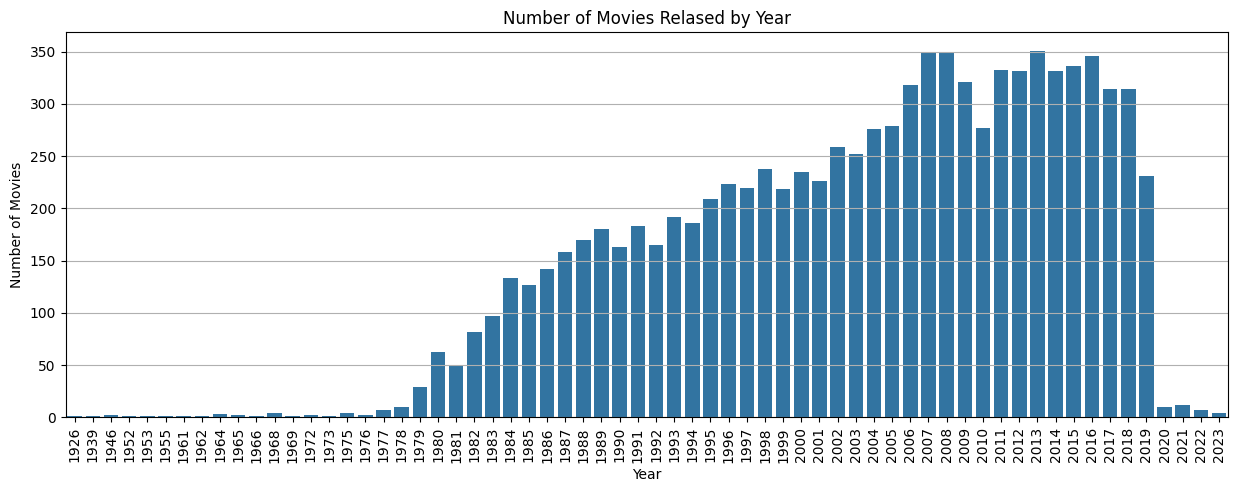

In [40]:
plt.figure(figsize = (15,5))
sns.barplot(x='Released Year', y='Released Year', data=movie_data, errorbar = None, estimator = 'count')
plt.title('Number of Movies Relased by Year')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

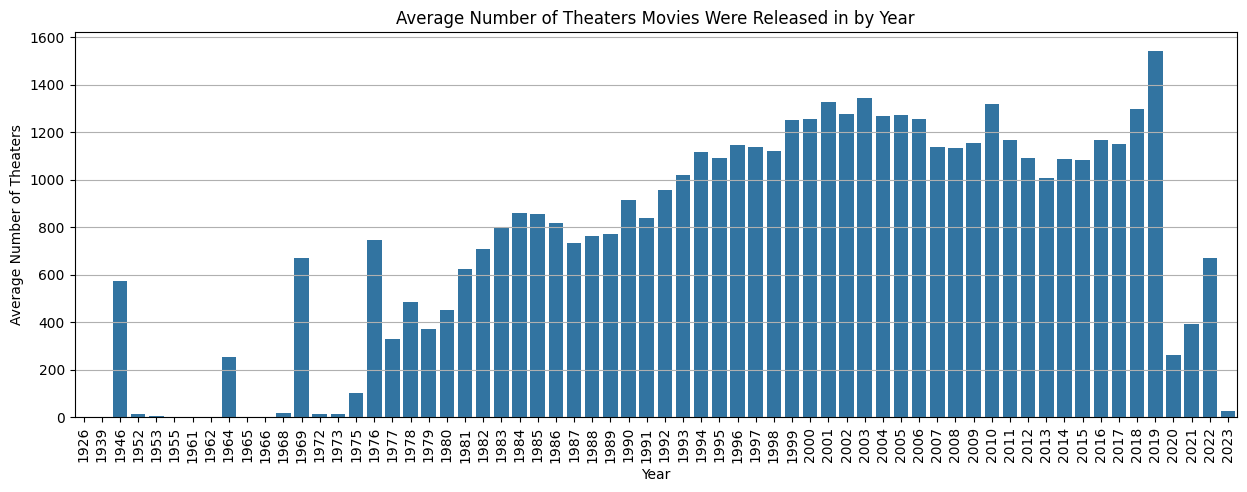

In [41]:
#pivot_avg = movie_data.pivot_table(index='Released Year', values='Number of Theaters', aggfunc='mean')
#pivot_avg.reset_index(inplace=True)
plt.figure(figsize = (15,5))
sns.barplot(x='Released Year', y='Number of Theaters', data=movie_data, errorbar = None, estimator ='mean')
plt.title('Average Number of Theaters Movies Were Released in by Year')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.xlabel('Year')
plt.ylabel('Average Number of Theaters')
plt.show()

As time has gone on we have seen an increase in the number of movies released each year. Our data set is not capturing all movies released past 2019, therefore we don't want to put any weight of time. We can use the two graphs above to get a better picture of when movies started to become more popular. The first graph shows that 1979 is when we see an increase in movies being released. This roughly lines up with the average number of movie theaters a movie was released in as we see an uptick starting in 1976. When we compare the number of movies released in 1976, 1977 and 1978 we don't see that there were a lot of movies released, but they were released to a lot of movie theaters. Therefore we are going to remove any movies released prior to 1976.

In [42]:
movie_data = movie_data[movie_data['Released Year'] > 1975]

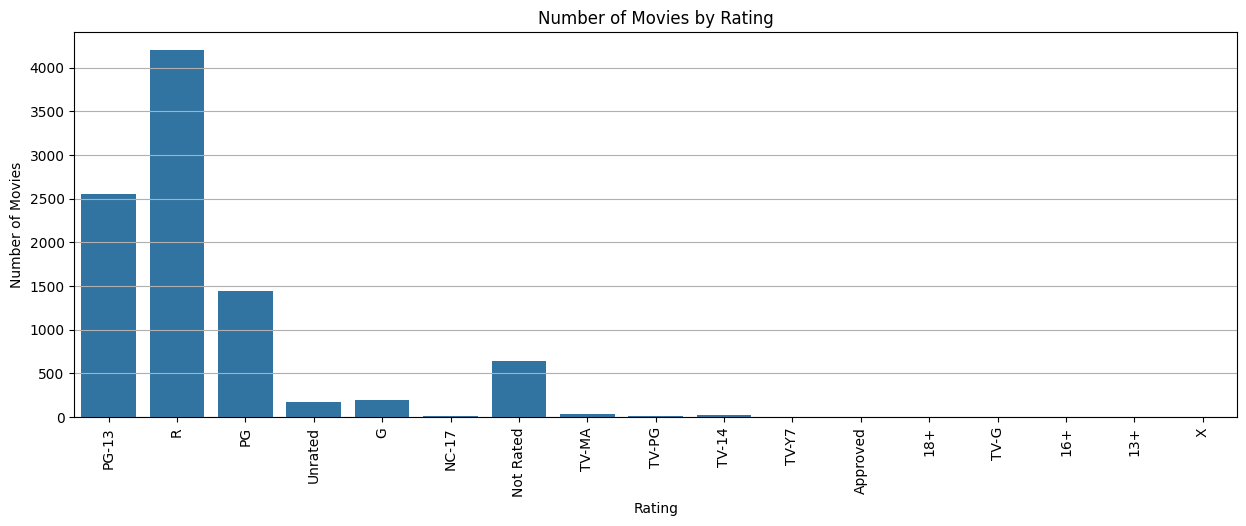

In [43]:
plt.figure(figsize = (15,5))
sns.barplot(x='Rated', y='Released Year', data=movie_data, errorbar = None, estimator = 'count')
plt.title('Number of Movies by Rating')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.show()

Since we are only looking at movies we will want to remove any rating that is not part of the US movie rating system. Therefore we will only include ratings that are G, PG, PG-13 and R.

In [44]:
pivot_avg = movie_data.pivot_table(index='Rated', values='Released Year', aggfunc='count')
pivot_avg.reset_index()

,Rated,Released Year
0,13+,1
1,16+,1
2,18+,1
3,Approved,1
4,G,198
5,NC-17,15
6,Not Rated,644
7,PG,1446
8,PG-13,2552
9,R,4196


In [45]:
movie_data = movie_data[movie_data['Rated'].isin(['G', 'PG', 'PG-13', 'R'])]

In [46]:
pivot_avg = movie_data.pivot_table(index='Rated', values='Released Year', aggfunc='count')
pivot_avg.reset_index()

,Rated,Released Year
0,G,198
1,PG,1446
2,PG-13,2552
3,R,4196


Can compare to the pivot above and see that we still have the same number of G, PG, PG-13 and R rated movies.

Lets look at field belongs to collection

In [47]:
movie_data['belongs_to_collection']

0                                                      NaN
1                                                      NaN
2                                                      NaN
3                                                      NaN
4                                                      NaN
                               ...                        
13000    {'id': 93220, 'name': 'Miss Congeniality Colle...
13001                                                  NaN
13002                                                  NaN
13003                                                  NaN
13004    {'id': 115822, 'name': 'Dracula 2000 Collectio...
Name: belongs_to_collection, Length: 8392, dtype: object

Let's extract out the name of the collection the movies belong to

In [48]:
def get_collection_name(row):
    # Check if 'belongs_to_collection' is a string
    if isinstance(row['belongs_to_collection'], str):
        try:
            row_string = row['belongs_to_collection'].replace("'", '"')
            str_to_json = json.loads(row_string)
            return str_to_json.get('name')
        except json.JSONDecodeError as e:
            return None
    return None

movie_data['Collection Name'] = movie_data.apply(get_collection_name, axis=1)

In [49]:
unique_row_count = movie_data['Collection Name'].drop_duplicates().nunique()
unique_row_count

699

With almost 700 unique collections in stead of dummy coding all these to see if being in a specific collection helps we are going to see if being in a collection (Yes) vs not being in a collection (No) and see if that impacts our model

In [50]:
def get_in_collection(row):
    if pd.notna(row['Collection Name']):
        return 'Yes'
    return 'No' 

movie_data['In Collection'] = movie_data.apply(get_in_collection, axis=1)

In [51]:
pivot_avg = movie_data.pivot_table(index='In Collection', values='Released Year', aggfunc='count')
pivot_avg.reset_index()

,In Collection,Released Year
0,No,7062
1,Yes,1330


Now lets take a look at the budget column and view the values

In [52]:
movie_data['budget'].describe().T

count    8.392000e+03
mean     2.290035e+07
std      3.753816e+07
min      0.000000e+00
25%      0.000000e+00
50%      8.500000e+06
75%      3.000000e+07
max      3.790000e+08
Name: budget, dtype: float64

Looks like we have budget values of 0. We will want to remove those 

In [53]:
zero_budget_count = movie_data[movie_data['budget'] == 0]
zero_budget_count['budget'].count()

2944

Remove zero budget columns

In [54]:
movie_data = movie_data[movie_data['budget'] > 0]
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5448 entries, 0 to 13004
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   imdbID                            5448 non-null   object 
 1   TT URL                            5448 non-null   object 
 2   RL URL                            5448 non-null   object 
 3   Number of Theaters                5448 non-null   int32  
 4   tmdbID                            5448 non-null   int64  
 5   url                               5448 non-null   object 
 6   budget                            5448 non-null   float64
 7   original_title                    5448 non-null   object 
 8   title                             5448 non-null   object 
 9   overview                          5448 non-null   object 
 10  production_company                5448 non-null   object 
 11  belongs_to_collection             1311 non-null   object 
 12  omdb title

Let's look at genre column

In [55]:
movie_data['Genre']

0                Biography, Drama
1         Drama, Musical, Romance
2         Biography, Drama, Music
5                 Comedy, Romance
9         Comedy, Family, Fantasy
                   ...           
12998      Comedy, Drama, Fantasy
12999              Romance, Drama
13000       Action, Comedy, Crime
13001    Adventure, Comedy, Crime
13004     Action, Fantasy, Horror
Name: Genre, Length: 5448, dtype: object

Let's find all the uniqure genres

In [56]:
genre_df = movie_data['Genre'].str.split(',', expand=True).apply(lambda x: x.str.strip())
unique_genre = set()
for index, row in genre_df.iterrows():
        unique_genre.update(row)
unique_genre

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 None,
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western'}

We will remove None from the set of unique genres

In [57]:
unique_genre.discard(None)
len(unique_genre)

22

Make unique column per genre and put true if the movie is part of that genre and false if it is not

In [58]:
for i in sorted(unique_genre):
    row_val = []
    for index, row in movie_data.iterrows():
        genre_split = row['Genre'].split(",")
        genre_split = [re.sub(r'\s', "", g) for g in genre_split]

        if i in genre_split:
            row_val += [True]
        else:
            row_val += [False]
    movie_data[i] = row_val       

In [59]:
movie_data.head(5)

,imdbID,TT URL,RL URL,Number of Theaters,tmdbID,url,budget,original_title,title,overview,production_company,belongs_to_collection,omdb title,year,Rated,Released,Runtime,Genre,Director,Actors,Plot,Language,Country,Poster,Ratings_IMDB,imdbVotes,Type,BoxOffice,Response,USA Released,Month,Released Year,Adjusted_Opening_Weekend_Revenue,Collection Name,In Collection,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0338751,https://www.boxofficemojo.com/title/tt00338751...,https://www.boxofficemojo.com/release/rl742753...,40,2567,https://api.themoviedb.org/3/movie/2567?api_ke...,110000000.0,The Aviator,The Aviator,A biopic depicting the life of filmmaker and a...,"[{'id': 14, 'logo_path': '/m6AHu84oZQxvq7n1rsv...",NaN,The Aviator,2004.0,PG-13,12/25/2004,170.0,"Biography, Drama",Martin Scorsese,"Leonardo DiCaprio, Cate Blanchett, Kate Beckin...",A biopic depicting the early years of legendar...,"English, Persian","United States, Germany",https://m.media-amazon.com/images/M/MV5BZTYzMj...,0.75,"376,165",movie,"$102,610,330",True,Yes,12,2004,1.387753e+06,None,No,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,tt0293508,https://www.boxofficemojo.com/title/tt00293508...,https://www.boxofficemojo.com/release/rl121480...,622,9833,https://api.themoviedb.org/3/movie/9833?api_ke...,70000000.0,The Phantom of the Opera,The Phantom of the Opera,"Deformed since birth, a bitter man known only ...","[{'id': 174, 'logo_path': '/IuAlhI9eVC9Z8UQWOI...",NaN,The Phantom of the Opera,2004.0,PG-13,1/21/2005,143.0,"Drama, Musical, Romance",Joel Schumacher,"Gerard Butler, Emmy Rossum, Patrick Wilson",A young soprano becomes the obsession of a dis...,"English, Italian","United Kingdom, United States",https://m.media-amazon.com/images/M/MV5BNDczNz...,0.72,"128,266",movie,"$51,293,931",True,Yes,1,2005,6.459034e+06,None,No,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False
2,tt0363473,https://www.boxofficemojo.com/title/tt00363473...,https://www.boxofficemojo.com/release/rl332637...,6,6478,https://api.themoviedb.org/3/movie/6478?api_ke...,25000000.0,Beyond the Sea,Beyond the Sea,Based on the life and career of legendary ente...,"[{'id': 1632, 'logo_path': '/cisLn1YAUuptXVBa0...",NaN,Beyond the Sea,2004.0,PG-13,12/29/2004,118.0,"Biography, Drama, Music",Kevin Spacey,"Kevin Spacey, Kate Bosworth, John Goodman","A swooning study of ""Mack the Knife"" singer Bo...","English, Italian","United Kingdom, Germany, United States",https://m.media-amazon.com/images/M/MV5BMTY2Mz...,0.67,"15,400",movie,"$6,318,709",True,Yes,12,2004,7.320947e+04,None,No,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
5,tt0290002,https://www.boxofficemojo.com/title/tt00290002...,https://www.boxofficemojo.com/release/rl862094...,3518,693,https://api.themoviedb.org/3/movie/693?api_key...,80000000.0,Meet the Fockers,Meet the Fockers,Hard-to-crack ex-CIA man Jack Byrnes and his w...,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...","{'id': 51509, 'name': 'Meet the Parents Collec...",Meet the Fockers,2004.0,PG-13,12/22/2004,115.0,"Comedy, Romance",Jay Roach,"Ben Stiller, Robert De Niro, Blythe Danner",All hell breaks loose when the Byrnes family m...,"English, Spanish, Hebrew",United States,https://m.media-amazon.com/images/M/MV5BNmQyYm...,0.63,"281,835",movie,"$279,261,160",True,Yes,12,2004,7.459554e+07,Meet the Parents Collection,Yes,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
9,tt0396592,https://www.boxofficemojo.com/title/tt00396592...,https://www.boxofficemojo.com/release/rl542344...,2674,15045,https://api.themoviedb.org/3/movie/15045?api_k...,26000000

In [60]:
#Dropping unneeded columns
movie_data_final = pd.DataFrame(movie_data.drop(columns=['imdbID', 'original_title', 'TT URL', 'RL URL' , 'tmdbID', 'url', 'title', 'overview', 'production_company','belongs_to_collection'
                         ,'Collection Name', 'omdb title','year','Released', 'Plot', 'Poster', 'imdbVotes', 'Type', 'BoxOffice', 'Response'
                         ,'Director', 'Actors', 'Language','Country', 'USA Released']).copy())

In [61]:
movie_data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5448 entries, 0 to 13004
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Number of Theaters                5448 non-null   int32  
 1   budget                            5448 non-null   float64
 2   Rated                             5448 non-null   object 
 3   Runtime                           5448 non-null   float64
 4   Genre                             5448 non-null   object 
 5   Ratings_IMDB                      5448 non-null   float64
 6   Month                             5448 non-null   int32  
 7   Released Year                     5448 non-null   int32  
 8   Adjusted_Opening_Weekend_Revenue  5448 non-null   float64
 9   In Collection                     5448 non-null   object 
 10  Action                            5448 non-null   bool   
 11  Adventure                         5448 non-null   bool   
 12  Animation 

Show final correlation matrix

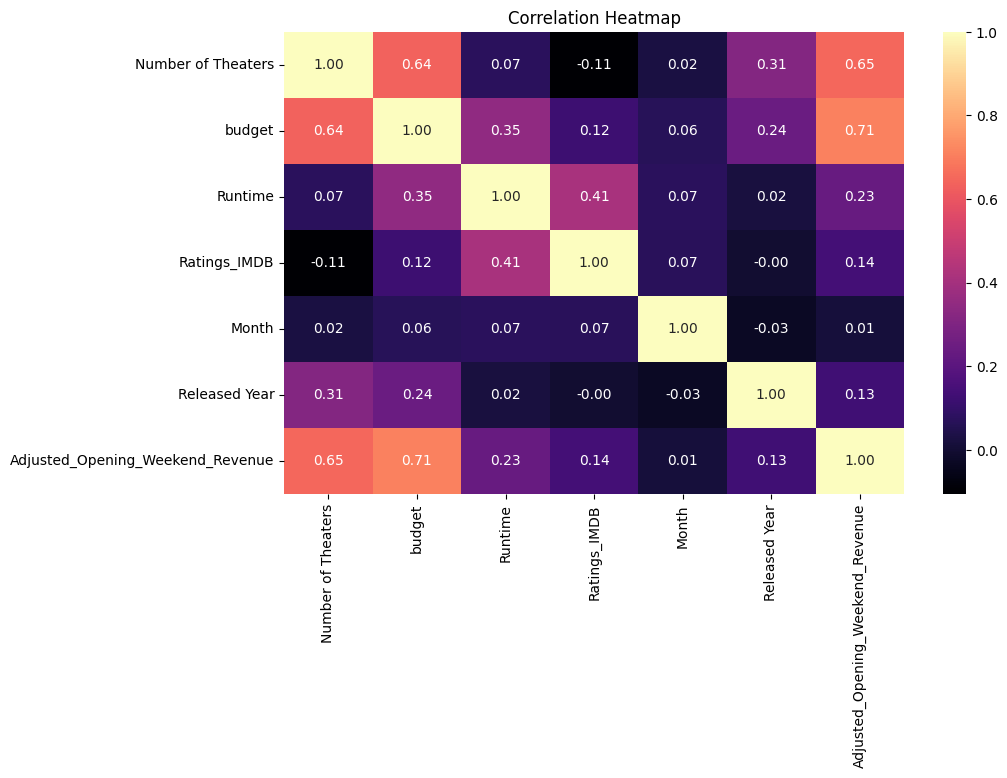

In [62]:
genre_cols = movie_data_final.select_dtypes(include=[np.number])
correlation_matrix = genre_cols.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, cmap= 'magma', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Based on the correlation matrix above, we see a high correlation with revenue and number of theaters. We also see a high correlation between budget and revenue.

Scale numerical features

In [63]:
numerical_cols = ['Number of Theaters' , 'budget', 'Runtime', 'Ratings_IMDB','Released Year', 'Adjusted_Opening_Weekend_Revenue']
movie_data_final[numerical_cols] = StandardScaler().fit_transform(movie_data_final[numerical_cols])
movie_data_final.head(5)

,Number of Theaters,budget,Rated,Runtime,Genre,Ratings_IMDB,Month,Released Year,Adjusted_Opening_Weekend_Revenue,In Collection,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,-1.261896,1.794596,PG-13,3.550678,"Biography, Drama",1.213751,12,0.084199,-0.620952,No,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,-0.814091,0.833952,PG-13,2.024311,"Drama, Musical, Romance",0.909700,1,0.181839,-0.445894,No,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False
2,-1.288056,-0.246772,PG-13,0.611009,"Biography, Drama, Music",0.402947,12,0.084199,-0.666330,No,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
5,1.414161,1.074113,PG-13,0.441413,"Comedy, Romance",-0.002456,12,0.084199,1.906142,Yes,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
9,0.764767,-0.222756,PG,-0.802293,"Comedy, Family, Fantasy",-1.928117,12,0.084199,-0.109342,No,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False


Dummy code categorical variables. For this model we will consider month to be categorical.

In [64]:
movie_data_final = pd.get_dummies(movie_data_final, columns=['Rated', 'Month', 'In Collection', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy',
 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
 'Western'])

In [65]:
movie_data_final.shape

(5448, 69)

Drope Genre column as not needed any more

In [66]:
movie_data_final.drop(columns=['Genre'], axis=1, inplace=True)

Do train test split. We will do 80/20 split of data

In [67]:
df_x = pd.DataFrame(movie_data_final.drop(columns='Adjusted_Opening_Weekend_Revenue').copy())
df_y= pd.DataFrame(movie_data_final['Adjusted_Opening_Weekend_Revenue'])

X_train, X_test,y_train,y_test = train_test_split(df_x ,df_y, test_size= 0.20, random_state= rand_state)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4358, 67)
(1090, 67)
(4358, 1)
(1090, 1)


In [68]:
df_x

,Number of Theaters,budget,Runtime,Ratings_IMDB,Released Year,Rated_G,Rated_PG,Rated_PG-13,Rated_R,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,In Collection_No,In Collection_Yes,Action_False,Action_True,Adventure_False,Adventure_True,Animation_False,Animation_True,Biography_False,Biography_True,Comedy_False,Comedy_True,Crime_False,Crime_True,Documentary_False,Documentary_True,Drama_False,Drama_True,Family_False,Family_True,Fantasy_False,Fantasy_True,History_False,History_True,Horror_False,Horror_True,Music_False,Music_True,Musical_False,Musical_True,Mystery_False,Mystery_True,News_False,News_True,Romance_False,Romance_True,Sci-Fi_False,Sci-Fi_True,Sport_False,Sport_True,Thriller_False,Thriller_True,War_False,War_True,Western_False,Western_True
0,-1.261896,1.794596,3.550678,1.213751,0.084199,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,True,False,True,False,False,True,True,False,True,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False
1,-0.814091,0.833952,2.024311,0.909700,0.181839,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False,False,True,True,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False
2,-1.288056,-0.246772,0.611009,0.402947,0.084199,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,True,False,True,False,False,True,True,False,True,False,True,False,False,True,True,False,True,False,True,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False
5,1.414161,1.074113,0.441413,-0.002456,0.084199,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,True,False,True,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False
9,0.764767,-0.222756,-0.802293,-1.928117,0.084199,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,True,False,True,False,True,False,False,True,True,False,True,False,True,False,False,True,False,True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12998,0.544711,0.593791,1.006734,0.504297,-0.306363,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,True,False,True,False,True,False,False,True,True,False,True,False,False,True,True,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False
12999,-1.287287,-0.607014,1.572055,0.706999,-0.306363,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False
13000,0.760150,0.233550,0.102221,-0.002456,-0.306363,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False

In [69]:
#Create output dataframe
column_names = ['Model Type' ,'R^2', 'MSE', 'RMSE']
df_models = pd.DataFrame(columns=column_names)

In [70]:
all_models = [LinearRegression(), DecisionTreeRegressor(random_state = rand_state), RandomForestRegressor( random_state = rand_state)]

In [71]:
output = []
for curr_model in all_models:
    print(curr_model)
    curr_model.fit(X_train,y_train.Adjusted_Opening_Weekend_Revenue)
    preds_dummy = curr_model.predict(X_train)
    r2_scores = cross_val_score(curr_model, X_train, y_train.Adjusted_Opening_Weekend_Revenue, cv=10, scoring='r2').mean()
    mse = cross_val_score(estimator= curr_model, X= X_train, y= y_train.Adjusted_Opening_Weekend_Revenue, cv= 10, scoring= 'neg_mean_squared_error')
    mse_mean = mse.mean()
    rmse = np.sqrt(-mse_mean)
    rmse_mean = rmse.mean()
    output += [[str(curr_model).split("(")[0], r2_scores, mse_mean, rmse]]


df_models = pd.DataFrame(output, columns=['Model Type' ,'R^2', 'MSE', 'RMSE'])


LinearRegression()


DecisionTreeRegressor(random_state=425)
RandomForestRegressor(random_state=425)


In [72]:
df_models

,Model Type,R^2,MSE,RMSE
0,LinearRegression,0.640846,-0.377403,0.614332
1,DecisionTreeRegressor,0.534625,-0.484548,0.696095
2,RandomForestRegressor,0.787661,-0.222414,0.471608


In [73]:
#Calculate the number of cores your CPU has
num_cores = os.cpu_count()

In [74]:
#Create grid
param_grid = {'bootstrap': [True, False]
                , 'max_depth' : np.linspace(10,110,11,dtype=int)
                , 'max_features' : [1 ,'sqrt']        
                , 'min_samples_split': [2,5,10]
                , 'min_samples_leaf': [1,2,4]        
                , 'n_estimators': np.linspace(200,2000,10, dtype=int)
             }

#Final random forest model
final_rand_for = RandomForestRegressor()

#Perform random search
rand_search = RandomizedSearchCV(final_rand_for, param_distributions=param_grid, n_iter = 20, cv =3, n_jobs=num_cores-1,random_state = rand_state)

#Fit model
rand_search.fit(X_train, y_train.Adjusted_Opening_Weekend_Revenue)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20, n_jobs=7,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110]),
                                        'max_features': [1, 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000])},
                   random_state=425)

Pull best estimators out and calculate R^2, MSE and RMSE

In [75]:
best_estimator = rand_search.best_estimator_
best_estimator

RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      n_estimators=1200)

In [76]:
r2_scores_best = cross_val_score(best_estimator, X_train, y_train.Adjusted_Opening_Weekend_Revenue, cv=3, scoring='r2')
mse_scores_best = cross_val_score(rand_search.best_estimator_, X_train, y_train.Adjusted_Opening_Weekend_Revenue, cv=3, scoring='neg_mean_squared_error')
print(f'The R^2 values from the cross val scores are: {r2_scores_best}')
print(f'The MSE from the cross val scores are: {mse_scores_best}')
rmse_best = np.sqrt(-mse_scores_best)
print(f'The RMSE is: {rmse_best}')
print(f'The mean values for R^2: {r2_scores_best.mean():.2f}, mse: {mse_scores_best.mean():.2f} and RMSE: {rmse_best.mean():.2f}')

The R^2 values from the cross val scores are: [0.72812165 0.77559341 0.74622435]
The MSE from the cross val scores are: [-0.30307845 -0.23485982 -0.25881442]
The RMSE is: [0.55052562 0.48462338 0.50873806]
The mean values for R^2: 0.75, mse: -0.27 and RMSE: 0.51


We will look at which features are most important using a feature importance plot

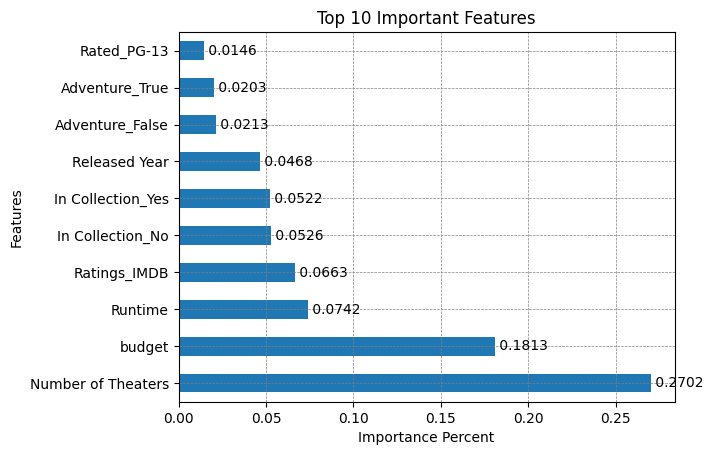

In [77]:
import_feats = (pd.Series(rand_search.best_estimator_.feature_importances_, index=X_train.columns).nlargest(10))
graph_type = import_feats.plot(kind='barh')
graph_type.grid(True, linestyle='--', linewidth=0.5, color='gray')
for index, value in enumerate(import_feats):
    graph_type.text(value, index, f' {value:.4f}', va='center')
graph_type.set_title('Top 10 Important Features')
graph_type.set_ylabel('Features')
graph_type.set_xlabel('Importance Percent')
plt.show()


We scraped a feature review from themoviedb.org and we used the plot of the movie from omdbapi.com and ran it through a natural language process model to get a sentiment score. We will now incorporate that into our model and see if it improves the overall score

In [78]:
NLP_data.head(5)

,imdbID,overview_NLG,overview_Sentiment,Featured Review,review_NLG,review_Sentiment
0,tt0293508,"deformed since birth , bitter man known phanto...",-0.5423,SENSATIONAL,sensational,0.0000
1,tt0361127,paedophile return hometown 12 year prison atte...,-0.5106,Great psychological study,great psychological study,0.6249
2,tt0369672,headstrong young woman return new orleans deat...,-0.5994,Literature-quoting lazy drama about a teen gir...,literature-quoting lazy drama teen girl two ol...,-0.3612
3,tt0396592,animated character fat albert emerges tv unive...,0.7845,Hey hey hey!,hey hey hey !,0.0000
4,tt0390123,realm unreal documentary reclusive chicago-bas...,-0.7964,This is a 2004 documentary film by Jessica Yu ...,2004 documentary film jessica yu introducing l...,-0.0258


We will combine it with the data frame movie_data based on the imdbID

In [79]:
movie_data_NLP = pd.merge(movie_data, NLP_data, on='imdbID', how='inner')

In [80]:
movie_data_NLP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 62 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   imdbID                            3173 non-null   object 
 1   TT URL                            3173 non-null   object 
 2   RL URL                            3173 non-null   object 
 3   Number of Theaters                3173 non-null   int32  
 4   tmdbID                            3173 non-null   int64  
 5   url                               3173 non-null   object 
 6   budget                            3173 non-null   float64
 7   original_title                    3173 non-null   object 
 8   title                             3173 non-null   object 
 9   overview                          3173 non-null   object 
 10  production_company                3173 non-null   object 
 11  belongs_to_collection             995 non-null    object 
 12  omdb t

Drop columns that are not needed

In [81]:
movie_data_NLP_final = pd.DataFrame(movie_data_NLP.drop(columns=['imdbID', 'original_title', 'TT URL', 'RL URL' , 'tmdbID', 'url', 'title', 'overview', 'production_company','belongs_to_collection'
                         ,'Collection Name', 'omdb title','year','Released', 'Plot', 'Poster', 'imdbVotes', 'Type', 'BoxOffice', 'Response'
                         ,'Director', 'Actors', 'Language','Country', 'USA Released', 'Genre', 'overview_NLG','Featured Review', 'review_NLG']).copy())

In [82]:
movie_data_NLP_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Number of Theaters                3173 non-null   int32  
 1   budget                            3173 non-null   float64
 2   Rated                             3173 non-null   object 
 3   Runtime                           3173 non-null   float64
 4   Ratings_IMDB                      3173 non-null   float64
 5   Month                             3173 non-null   int32  
 6   Released Year                     3173 non-null   int32  
 7   Adjusted_Opening_Weekend_Revenue  3173 non-null   float64
 8   In Collection                     3173 non-null   object 
 9   Action                            3173 non-null   bool   
 10  Adventure                         3173 non-null   bool   
 11  Animation                         3173 non-null   bool   
 12  Biogra

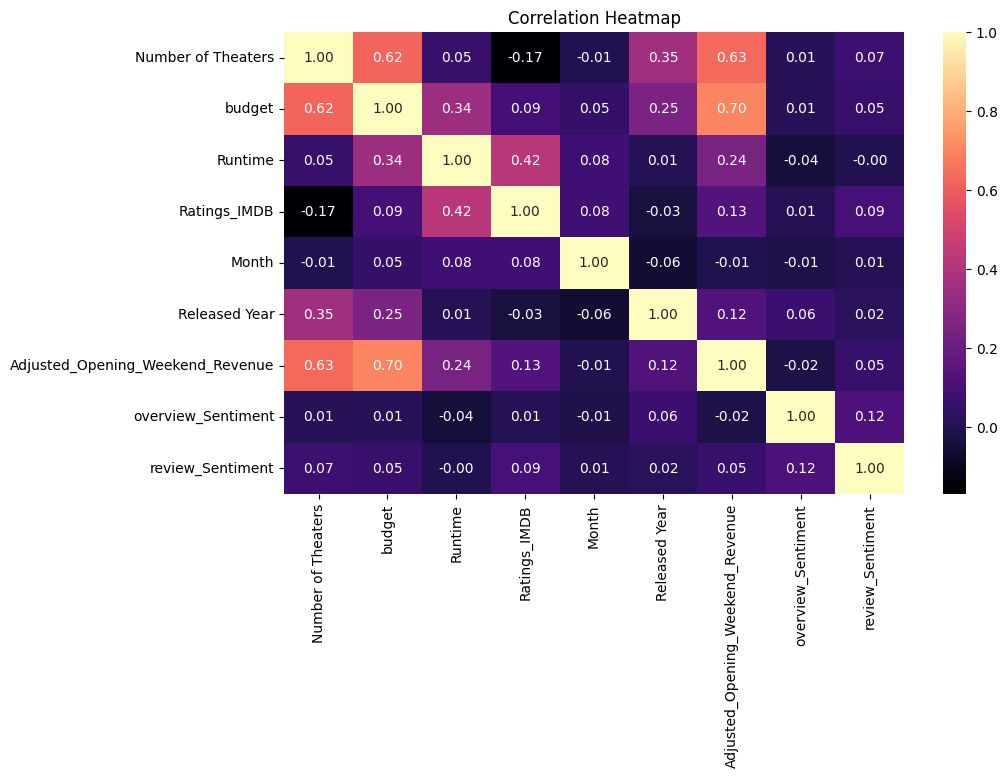

In [83]:
genre_cols = movie_data_NLP_final.select_dtypes(include=[np.number])
correlation_matrix = genre_cols.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, cmap= 'magma', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

When we add overview sentiment and review sentiment to the correlation matrix we don't see any high correlation with any of the variables.

Scale data to put into the model

In [84]:
numerical_cols_NLP = ['Number of Theaters' , 'budget', 'Runtime', 'Ratings_IMDB','Released Year', 'Adjusted_Opening_Weekend_Revenue', 'review_Sentiment', 'overview_Sentiment']
movie_data_NLP_final[numerical_cols] = StandardScaler().fit_transform(movie_data_NLP_final[numerical_cols])
movie_data_NLP_final.head(5)

,Number of Theaters,budget,Rated,Runtime,Ratings_IMDB,Month,Released Year,Adjusted_Opening_Weekend_Revenue,In Collection,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,overview_Sentiment,review_Sentiment
0,-1.065530,0.501264,PG-13,1.745918,0.745239,1,0.057137,-0.572564,No,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,-0.5423,0.0000
1,0.499773,-0.398591,PG,-0.901587,-2.151973,12,-0.036750,-0.289101,No,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,0.7845,0.0000
2,0.184729,-0.725811,PG-13,-0.477986,-1.013783,1,0.057137,0.371188,Yes,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,-0.3182,-0.9474
3,0.385350,-0.316786,PG-13,1.375267,0.848711,1,0.057137,0.374444,No,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,-0.0772,0.6808
4,-0.294321,-0.398591,PG-13,-0.848637,-0.703367,3,-0.975626,-0.552381,No,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.1779,0.4404


In [85]:
movie_data_NLP_final = pd.get_dummies(movie_data_NLP_final, columns=['Rated', 'Month', 'In Collection', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy',
 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
 'Western'])

In [86]:
movie_data_NLP_final.shape

(3173, 70)

In [87]:
df_x_NLP = pd.DataFrame(movie_data_NLP_final.drop(columns='Adjusted_Opening_Weekend_Revenue').copy())
df_y_NLP = pd.DataFrame(movie_data_NLP_final['Adjusted_Opening_Weekend_Revenue'])

X_train_NLP, X_test_NLP,y_train_NLP,y_test_NLP = train_test_split(df_x_NLP ,df_y_NLP, test_size= 0.20, random_state= rand_state)
print(X_train_NLP.shape)
print(X_test_NLP.shape)
print(y_train_NLP.shape)
print(y_test_NLP.shape)

(2538, 69)
(635, 69)
(2538, 1)
(635, 1)


In [88]:
#Create output dataframe
column_names = ['Model Type' ,'R^2', 'MSE', 'RMSE']
df_models_NLP = pd.DataFrame(columns=column_names)

In [89]:
all_models = [LinearRegression(), DecisionTreeRegressor(random_state = rand_state), RandomForestRegressor( random_state = rand_state)]

In [90]:
output = []
for curr_model in all_models:
    print(curr_model)
    curr_model.fit(X_train_NLP,y_train_NLP.Adjusted_Opening_Weekend_Revenue)
    preds_dummy = curr_model.predict(X_train_NLP)
    r2_scores = cross_val_score(curr_model, X_train_NLP, y_train_NLP.Adjusted_Opening_Weekend_Revenue, cv=10, scoring='r2').mean()
    mse = cross_val_score(estimator= curr_model, X= X_train_NLP, y= y_train_NLP.Adjusted_Opening_Weekend_Revenue, cv= 10, scoring= 'neg_mean_squared_error')
    mse_mean = mse.mean()
    rmse = np.sqrt(-mse_mean)
    rmse_mean = rmse.mean()
    output += [[str(curr_model).split("(")[0], r2_scores, mse_mean, rmse]]


df_models_NLP = pd.DataFrame(output, columns=['Model Type' ,'R^2', 'MSE', 'RMSE'])

LinearRegression()


DecisionTreeRegressor(random_state=425)
RandomForestRegressor(random_state=425)


In [91]:
df_models_NLP

,Model Type,R^2,MSE,RMSE
0,LinearRegression,0.639319,-0.368602,0.607126
1,DecisionTreeRegressor,0.486548,-0.521355,0.722049
2,RandomForestRegressor,0.762586,-0.242719,0.492665


In [92]:
#Create grid
param_grid = {'bootstrap': [True, False]
                , 'max_depth' : np.linspace(10,110,11,dtype=int)
                , 'max_features' : [1 ,'sqrt']        
                , 'min_samples_split': [2,5,10]
                , 'min_samples_leaf': [1,2,4]        
                , 'n_estimators': np.linspace(200,2000,10, dtype=int)
             }

#Final random forest model
final_rand_for_NLP = RandomForestRegressor()

#Perform random search
rand_search_NLP = RandomizedSearchCV(final_rand_for_NLP, param_distributions=param_grid, n_iter = 20, cv =3, n_jobs=num_cores-1,random_state = rand_state)

#Fit model
rand_search_NLP.fit(X_train_NLP, y_train_NLP.Adjusted_Opening_Weekend_Revenue)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20, n_jobs=7,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110]),
                                        'max_features': [1, 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000])},
                   random_state=425)

In [93]:
best_estimator_NLP = rand_search.best_estimator_
best_estimator_NLP

RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      n_estimators=1200)

In [94]:
r2_scores_best_NLP = cross_val_score(best_estimator_NLP, X_train_NLP, y_train_NLP.Adjusted_Opening_Weekend_Revenue, cv=3, scoring='r2')
mse_scores_best_NLP = cross_val_score(rand_search_NLP.best_estimator_, X_train_NLP, y_train_NLP.Adjusted_Opening_Weekend_Revenue, cv=3, scoring='neg_mean_squared_error')
print(f'The R^2 values from the cross val scores are: {r2_scores_best_NLP}')
print(f'The MSE from the cross val scores are: {mse_scores_best_NLP}')
rmse_best_NLP = np.sqrt(-mse_scores_best_NLP)
print(f'The RMSE is: {rmse_best_NLP}')
print(f'The mean values for R^2: {r2_scores_best_NLP.mean():.2f}, mse: {mse_scores_best_NLP.mean():.2f} and RMSE: {rmse_best_NLP.mean():.2f}')

The R^2 values from the cross val scores are: [0.72097123 0.70333882 0.6924358 ]
The MSE from the cross val scores are: [-0.28455952 -0.29057346 -0.32566063]
The RMSE is: [0.5334412  0.53904866 0.57066683]
The mean values for R^2: 0.71, mse: -0.30 and RMSE: 0.55


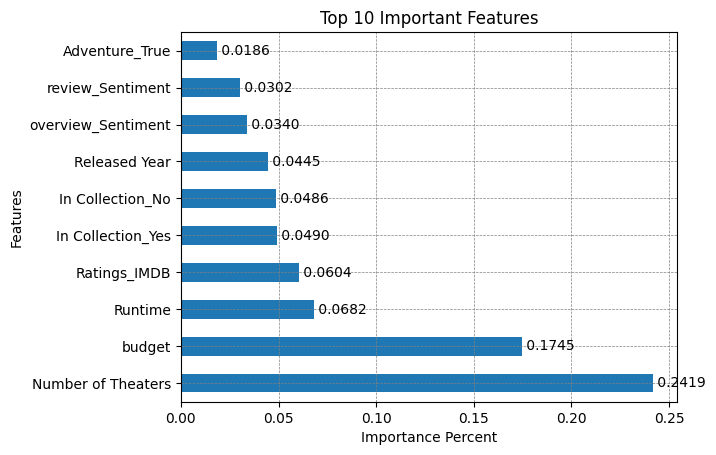

In [95]:
import_feats = (pd.Series(rand_search_NLP.best_estimator_.feature_importances_, index=X_train_NLP.columns).nlargest(10))
graph_type = import_feats.plot(kind='barh')
graph_type.grid(True, linestyle='--', linewidth=0.5, color='gray')
for index, value in enumerate(import_feats):
    graph_type.text(value, index, f' {value:.4f}', va='center')
graph_type.set_title('Top 10 Important Features')
graph_type.set_ylabel('Features')
graph_type.set_xlabel('Importance Percent')
plt.show()

Comparing the two models we see that the model that doesn't include NLP performs slightly better than that does. It has a R^2 of .74 where as the model that includes NLP has an R^2 of .72

Run the non NLP model against the test set 

In [96]:
preds_test = best_estimator.predict(X_test)
r2_score_test = r2_score(y_test, preds_test)
rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))

print(f'The R^2 for the test data is: {r2_score_test:.2f} and the RMSE for the test data is: {rmse_test:.2f}')

The R^2 for the test data is: 0.73 and the RMSE for the test data is: 0.46


Produce final tree. Show only top 3 of tree

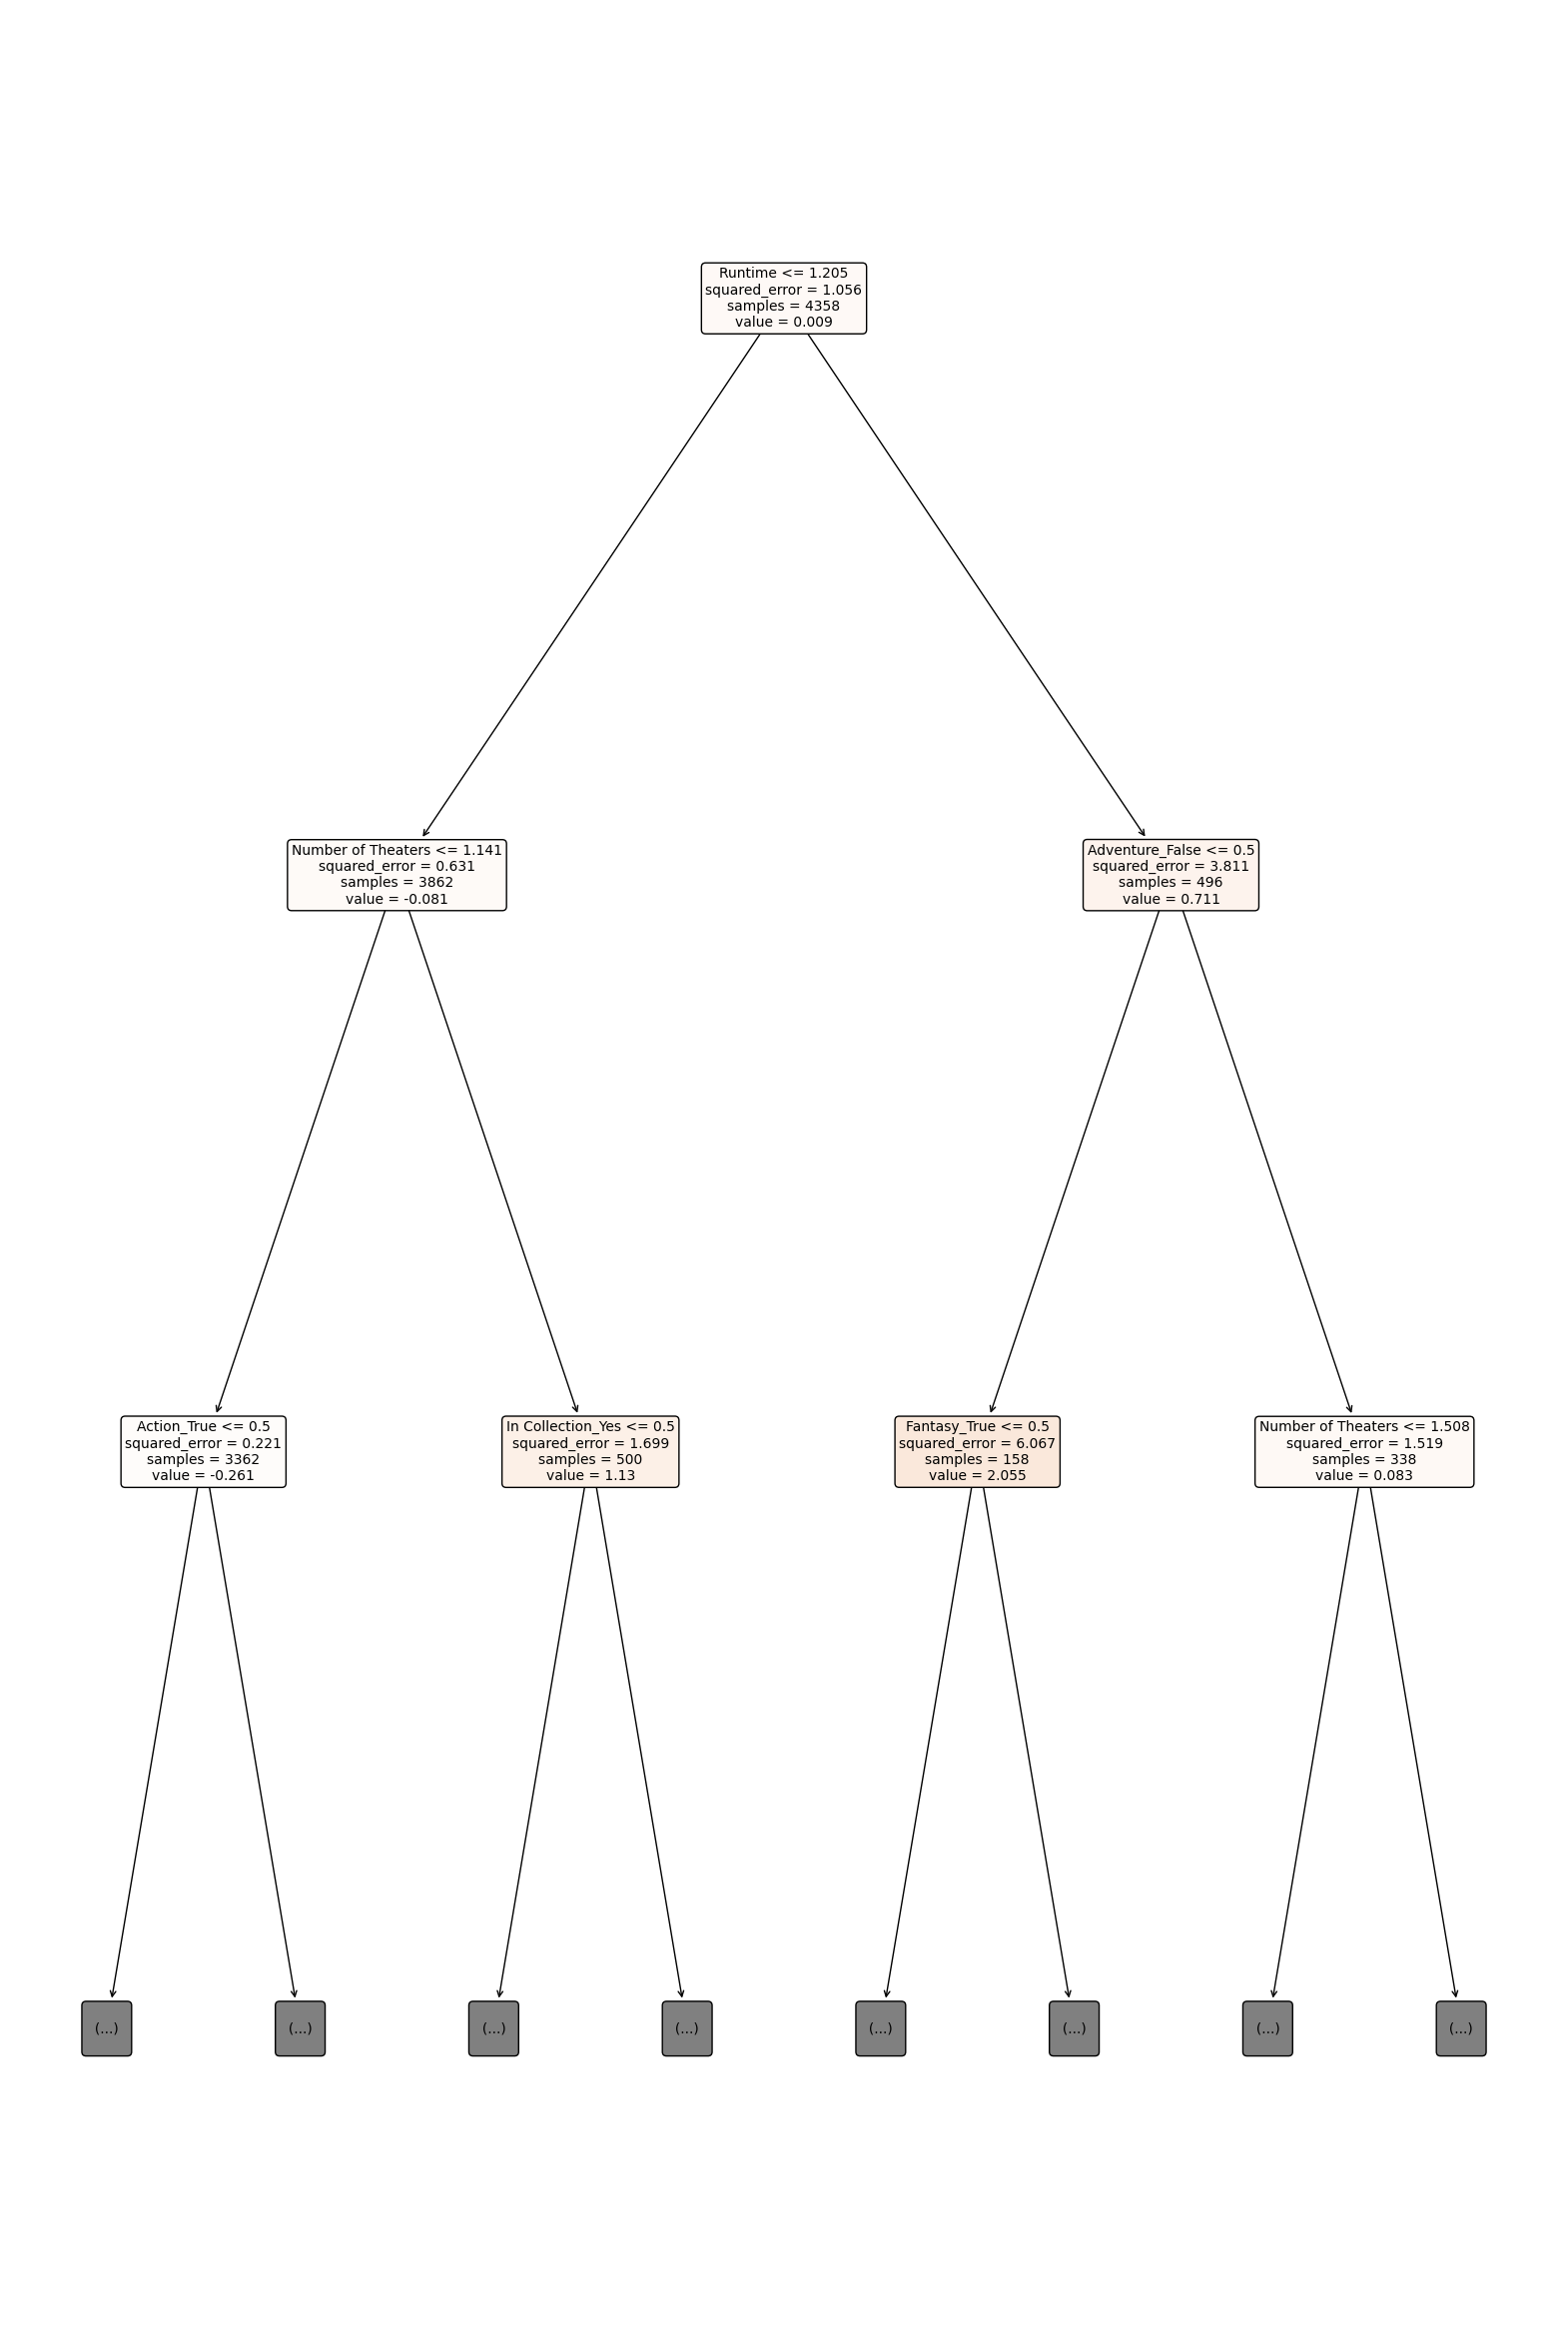

In [98]:
tree = best_estimator.estimators_[0]

# Convert feature names to a list
feature_names_list = list(X_train.columns)

# plot tree
plt.figure(figsize=(20,30))
plot_tree(tree, filled=True, feature_names=feature_names_list, rounded=True, fontsize=10, max_depth=2)
plt.show()